In [1]:
from datasets import Dataset, DatasetDict
import json


def reorder_json(data_old_structure, key_name):
    """Converts a dictionary of records into a Hugging Face Dataset object."""

    # Check the structure of each item in the dictionary
    for item_id, content in data_old_structure.items():
        # Check if the content is a dictionary and has the required keys
        if not (isinstance(content, dict) and 'original' in content and 'disfluent' in content):
            print(f"Validation failed: Item '{item_id}' has a un expected structure and will not be loaded.")
            return None

    data_new_structure = []
    for item_id, content in data_old_structure.items():
        record = {
            'id': item_id,
            'disfluent': content.get('disfluent'),
            'original': content.get('original')
        }
        data_new_structure.append(record)

    hugging_dataset = Dataset.from_list(data_new_structure)
    dataset_dict = DatasetDict({
        key_name: hugging_dataset
    })
    return dataset_dict


def load_dataset_from_raw(all_file_paths):
    """Load the dataset, """
    full_dataset = DatasetDict()
    for key_name, file_path in all_file_paths.items():
        try:
            print(f"Processing '{key_name}' split from {file_path}...")
            with open(file_path, 'r', encoding='utf-8') as f:
                loaded_file = json.load(f)

            single_reordered_dict = reorder_json(loaded_file, key_name=key_name)
            full_dataset[key_name] = single_reordered_dict[key_name]

        except FileNotFoundError:
            print(f" Error: The file '{file_path}' was not found. Skipping.")
        except Exception as e:
            print(f"An error occurred while processing {file_path}: {e}")

    print("\n✅ Raw Data Loaded Successfully:")
    return full_dataset

# 1. Define the exact paths to your data files.
file_paths = {
    'train': '../Data/raw/train.json',
    'val': '../Data/raw/dev.json',
    'test': '../Data/raw/test.json'
}

# 2. Initialize an empty DatasetDict to hold the combined results.
final_dataset = load_dataset_from_raw(file_paths)


Processing 'train' split from ../Data/raw/train.json...
Processing 'val' split from ../Data/raw/dev.json...
Processing 'test' split from ../Data/raw/test.json...

✅ Raw Data Loaded Successfully:


In [2]:
num_samples = 5
shuffled_dataset = final_dataset["train"].shuffle()
random_samples = shuffled_dataset.select(range(num_samples))
random_samples

Dataset({
    features: ['id', 'disfluent', 'original'],
    num_rows: 5
})

Map:   0%|          | 0/7182 [00:00<?, ? examples/s]

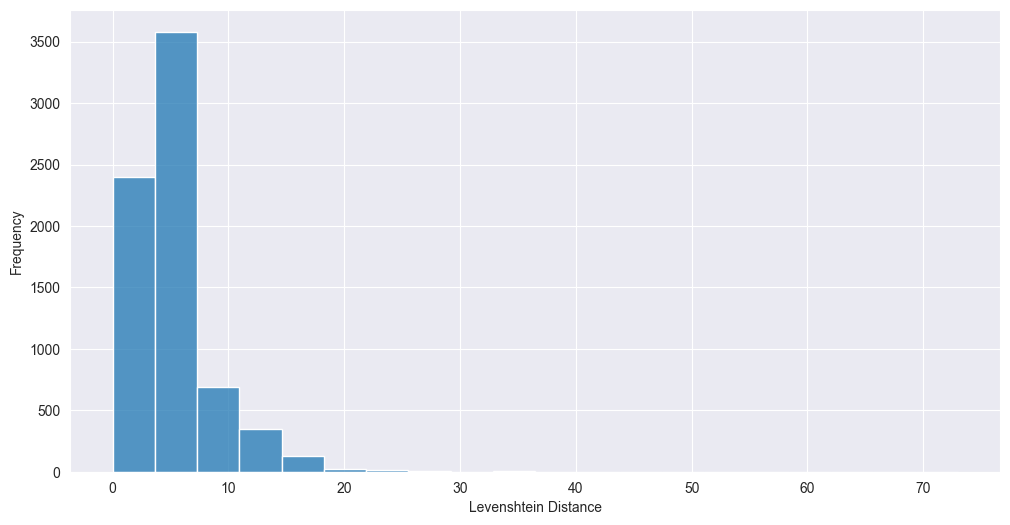

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

# --- 1. Quantify the difference using Levenshtein Distance ---
# Levenshtein distance measures the number of edits (insertions, deletions, substitutions)
# needed to change one string into the other.

def calculate_levenshtein(example):
    """Calculates the Levenshtein distance between disfluent and original sentences."""
    disfluent = example['disfluent']
    original = example['original']
    # We calculate distance on lowercased text to focus on structure, not capitalization.
    distance = nltk.edit_distance(disfluent.lower().split(), original.lower().split())
    example['levenshtein_distance'] = distance
    return example

# Apply the function to the training set
train_df_with_dist = final_dataset['train'].map(calculate_levenshtein)

# Convert to pandas DataFrame for easier plotting
df = train_df_with_dist.to_pandas()
# Plot the distribution of Levenshtein distances
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(df['levenshtein_distance'], bins=20)
ax.set_xlabel('Levenshtein Distance')
ax.set_ylabel('Frequency')
plt.show()

In [22]:
# show the largest differance
samples = df.nlargest(5, 'levenshtein_distance')[['disfluent', 'original', 'levenshtein_distance']]
samples

,disfluent,original,levenshtein_distance
6897,Question\tAnswer What is the dispensary subjec...,What do pharmacy technicians depend on less an...,73
535,Barro found high levels of inequality no let m...,Barro found there is much relation between inc...,33
1181,When a country is the core and developing nati...,One country's authority over a number of other...,33
4938,What condition what must be satisfied in order...,"According to Wilson's theorem, what factorial ...",31
1200,What did Hobson argue that imperialism was no ...,There is some debate that there is a not corre...,27


In [23]:
# Identify and count common filler words ---
FILLER_WORDS = {'uh', 'uhm', 'um', 'like', 'so', 'you know', 'i mean', 'no'}
def count_filler_words(example):
    """Counts the number of filler words in the disfluent sentence."""
    text = example['disfluent'].lower()
    count = sum(1 for filler in FILLER_WORDS if filler in text.split())
    example['filler_word_count'] = count
    return example

# Apply the function
train_df_with_fillers = final_dataset['train'].map(count_filler_words)
df_fillers = train_df_with_fillers.to_pandas()

# Display statistics
total_sentences = len(df_fillers)
sentences_with_fillers = len(df_fillers[df_fillers['filler_word_count'] > 0])
percentage_with_fillers = (sentences_with_fillers / total_sentences) * 100

print(f"Analysis of Filler Words in 'train' split:")
print(f"Total sentences: {total_sentences}")
print(f"Sentences containing at least one filler word: {sentences_with_fillers}")
print(f"Percentage of sentences with filler words: {percentage_with_fillers:.2f}%")


Map:   0%|          | 0/7182 [00:00<?, ? examples/s]

Analysis of Filler Words in 'train' split:
Total sentences: 7182
Sentences containing at least one filler word: 4344
Percentage of sentences with filler words: 60.48%


In [25]:
def calculate_lengths(example):
    """Calculates word counts for disfluent and original sentences."""
    example['disfluent_length'] = len(example['disfluent'].split())
    example['original_length'] = len(example['original'].split())
    example['length_difference'] = example['disfluent_length'] - example['original_length']
    return example

# Apply the function to the training data
train_df_with_lengths = final_dataset['train'].map(calculate_lengths)
df_lengths = train_df_with_lengths.to_pandas()
df_lengths

Map:   0%|          | 0/7182 [00:00<?, ? examples/s]

,id,disfluent,original,disfluent_length,original_length,length_difference
0,5a5918ff3e1742001a15cf7e,What do petrologists no what do unstable isoto...,What do unstable isotope studies indicate?,10,6,4
1,5ad4f40c5b96ef001a10a774,What is the second level of territorial divisi...,What is the basic unit of territorial division...,21,10,11
2,572684365951b619008f7543,Juvenile platyctenids no wow Which genus lack ...,Which genus lack tentacles and sheaths?,10,6,4
3,5729f799af94a219006aa70a,When a pathogen is met again scratch that I me...,Long-lived memory cells can remember previous ...,21,9,12
4,5ad3b9cd604f3c001a3fee87,What led to the Duke of Cumberland's rise to p...,What led to Newcastle's rise to power as milit...,16,10,6
...,...,...,...,...,...,...
7177,57265d86f1498d1400e8dd53,How does or actually what does the beroe do wh...,What does the beroe do when pursuing prey?,12,8,4
7178,5ad26aedd7d075001a429332,A static equilibrium between two no three sour...,A static equilibrium between three sources is ...,14,12,2
7179,5ad402ae604f3c001a3ffd61,When did Li Tan install the hostage no no when...,When did Li Tan reject a revolt?,15,7,8
7180,5ad4f1365b96ef001a10a70c,Where was no no um what was there a significan...,What was there a significant minority of in Wo...,16,11,5


In [4]:
# these items need to be deleted
items = [item for item in final_dataset['train']
         if item['id'] == "572634a789a1e219009ac56f"]

print(items)

[{'id': '572634a789a1e219009ac56f', 'disfluent': '#VALUE!', 'original': 'How is packet switching characterized '}]


Map:   0%|          | 0/7182 [00:00<?, ? examples/s]

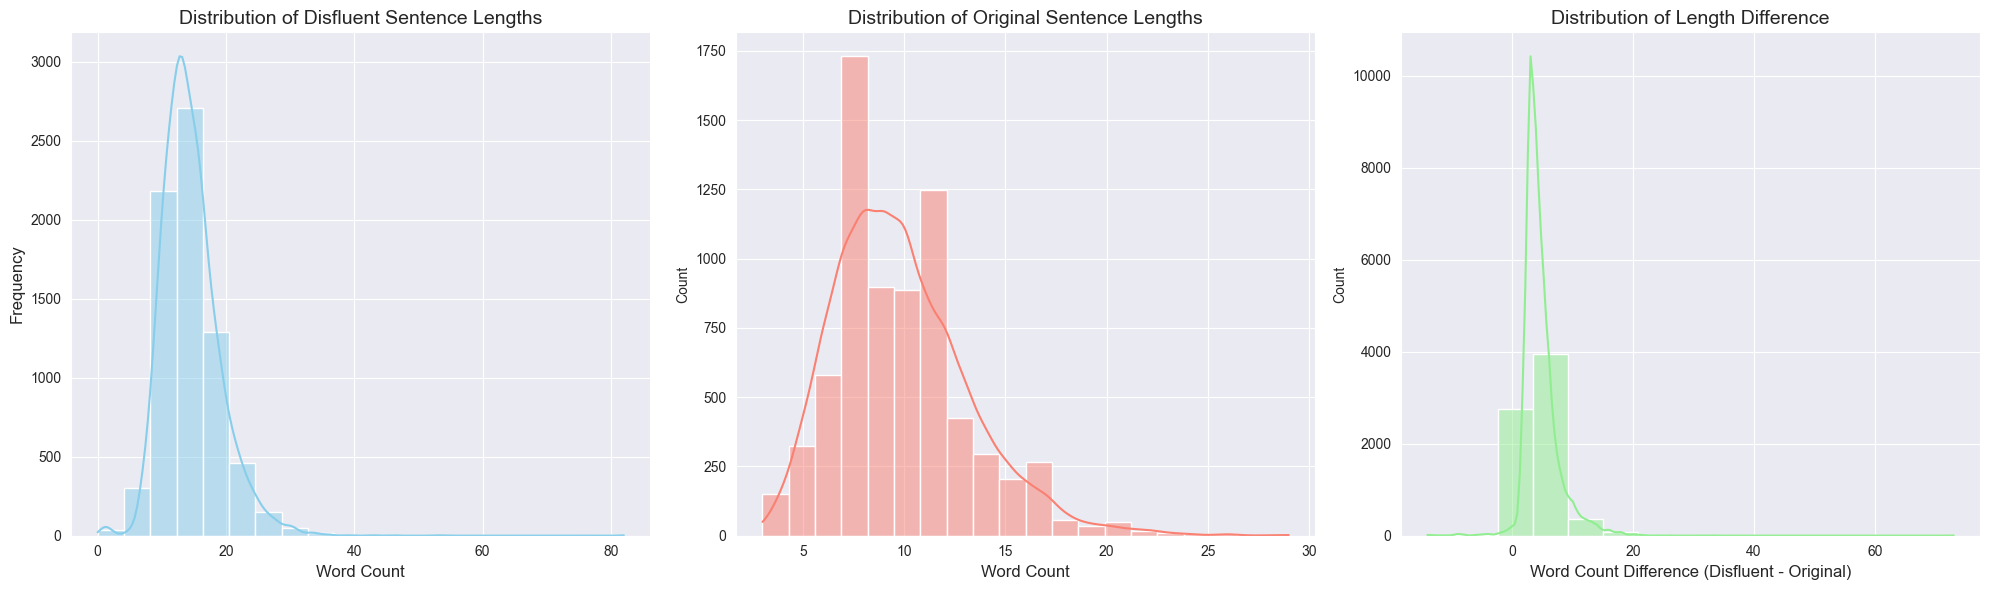

Key statistics for sequence lengths in 'train' split:
       disfluent_length  original_length  length_difference
count       7182.000000      7182.000000        7182.000000
mean          14.523810         9.830409           4.693400
std            4.554876         3.369577           2.994142
min            0.000000         3.000000         -14.000000
25%           11.000000         7.000000           3.000000
50%           14.000000         9.000000           4.000000
75%           17.000000        12.000000           6.000000
max           82.000000        29.000000          73.000000


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'final_dataset' is your DatasetDict

def calculate_lengths(example):
    """Calculates word counts for disfluent and original sentences."""
    example['disfluent_length'] = len(example['disfluent'].split())
    example['original_length'] = len(example['original'].split())
    example['length_difference'] = example['disfluent_length'] - example['original_length']
    return example

# Apply the function to the training data
train_df_with_lengths = final_dataset['train'].map(calculate_lengths)
df_lengths = train_df_with_lengths.to_pandas()

# --- Plot the distributions ---
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot for Disfluent Lengths
sns.histplot(df_lengths['disfluent_length'], bins=20, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Distribution of Disfluent Sentence Lengths', fontsize=14)
axes[0].set_xlabel('Word Count', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)

# Plot for Original Lengths
sns.histplot(df_lengths['original_length'], bins=20, kde=True, ax=axes[1], color='salmon')
axes[1].set_title('Distribution of Original Sentence Lengths', fontsize=14)
axes[1].set_xlabel('Word Count', fontsize=12)

# Plot for Length Difference
sns.histplot(df_lengths['length_difference'], bins=15, kde=True, ax=axes[2], color='lightgreen')
axes[2].set_title('Distribution of Length Difference', fontsize=14)
axes[2].set_xlabel('Word Count Difference (Disfluent - Original)', fontsize=12)

plt.tight_layout()
plt.show()

# Print key statistics
print("Key statistics for sequence lengths in 'train' split:")
print(df_lengths[['disfluent_length', 'original_length', 'length_difference']].describe())


In [6]:
# see values where
df_lengths[df_lengths['length_difference'] < 2]

,id,disfluent,original,disfluent_length,original_length,length_difference
112,572667e2f1498d1400e8de90,"which are older than the rocks themselves, Wha...","What foreign bodies, which are older than the ...",14,13,1
153,572a0a686aef0514001551ec,Question N/A,What were the two main theories of immunity at...,2,15,-13
192,57273d8bf1498d1400e8f501,what construction sector are Large public work...,"Large public works, dams, bridges, highways, w...",16,15,1
197,57264cfa708984140094c1c7,How long does flagella no sorry Cilia get?,Cilia can g ow up too what length?,8,8,0
264,572815d9ff5b5019007d9cc0,what modern form of travel brought visitors to...,"Other than the steamboat, what modern form of ...",13,13,0
...,...,...,...,...,...,...
6848,5726219489a1e219009ac2d0,#VALUE!,In cases of shared physical medium how are the...,1,10,-9
6921,5a67aa48f038b7001ab0c3ff,What missionary actions led to law in 1994 no ...,What did missionaries cause to become law in 1...,10,9,1
6951,5a551230134fea001a0e18cc,#VALUE!,DECnet stands for what?,1,4,-3
6994,5729e38daf94a219006aa6a1,the U.S has What level of economic mobility in...,What level of economic mobility does the U.S. ...,15,14,1


In [13]:
import pandas as pd
import nltk

# Comparing train-dev-val data to see if there are consistent

def calculate_levenshtein(example):
    """Calculates the Levenshtein distance between disfluent and original sentences."""
    disfluent = example['disfluent']
    original = example['original']
    distance = nltk.edit_distance(disfluent.lower().split(), original.lower().split())
    example['levenshtein_distance'] = distance
    return example

def analyze_split(dataset_split):
    """Runs analysis on a single split of the dataset."""
    # Add lengths and distances
    analyzed_split = dataset_split.map(
        lambda x: {
            'disfluent_length': len(x['disfluent'].split()),
            'original_length': len(x['original'].split()),
            'levenshtein_distance': nltk.edit_distance(x['disfluent'].lower().split(), x['original'].lower().split())
        }
    )

    # Convert to pandas for easy calculation of stats
    df = analyzed_split.to_pandas()

    stats = {
        'num_samples': len(df),
        'avg_disfluent_len': df['disfluent_length'].mean(),
        'avg_original_len': df['original_length'].mean(),
        'avg_levenshtein_dist': df['levenshtein_distance'].mean()
    }
    return stats

# --- Run analysis on all splits and compare ---
all_stats = []
for split_name in final_dataset.keys():
    print(f"Analyzing '{split_name}' split...")
    split_stats = analyze_split(final_dataset[split_name])
    split_stats['split'] = split_name
    all_stats.append(split_stats)

# Create a comparison DataFrame
comparison_df = pd.DataFrame(all_stats)
comparison_df = comparison_df.set_index('split')

print("\n--- EDA Comparison Across Data Splits ---")
print(comparison_df.round(2))


Analyzing 'train' split...


Map:   0%|          | 0/7182 [00:00<?, ? examples/s]

Analyzing 'val' split...


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Analyzing 'test' split...


Map:   0%|          | 0/3643 [00:00<?, ? examples/s]


--- EDA Comparison Across Data Splits ---
       num_samples  avg_disfluent_len  avg_original_len  avg_levenshtein_dist
split                                                                        
train         7182              14.52              9.83                  5.29
val           1000              14.41              9.65                  5.40
test          3643              15.22             10.50                  5.51


In [12]:
import numpy as np
import pandas as pd
from transformers import T5Tokenizer

train_df = final_dataset['train'].to_pandas()
val_df = final_dataset['val'].to_pandas()
test_df = final_dataset['test'].to_pandas()
all_data = pd.concat([train_df, val_df, test_df])

# Tokenize and Get Lengths ---our T5 model
tokenizer = T5Tokenizer.from_pretrained("t5-small")
source_lengths = [len(tokenizer(text, truncation=False).input_ids) for text in all_data['disfluent']]
target_lengths = [len(tokenizer(text, truncation=False).input_ids) for text in all_data['original']]


# Analyze the Lengths
percentiles = [90, 95, 98, 99, 100]
source_percentiles = np.percentile(source_lengths, percentiles)
target_percentiles = np.percentile(target_lengths, percentiles)

print("--- Source Text Token Length Analysis ---")
for p, v in zip(percentiles, source_percentiles):
    print(f"{p}th percentile: {v:.0f} tokens")

print("\n--- Target Text Token Length Analysis ---")
for p, v in zip(percentiles, target_percentiles):
    print(f"{p}th percentile: {v:.0f} tokens")

--- Source Text Token Length Analysis ---
90th percentile: 28 tokens
95th percentile: 31 tokens
98th percentile: 36 tokens
99th percentile: 39 tokens
100th percentile: 152 tokens

--- Target Text Token Length Analysis ---
90th percentile: 20 tokens
95th percentile: 23 tokens
98th percentile: 27 tokens
99th percentile: 29 tokens
100th percentile: 46 tokens
